In [2]:
import os, io, zipfile, requests
import pandas as pd
import matplotlib.pyplot as plt

RAW_DIR = "../data/raw"
PROC_DIR = "../data/processed"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

# Example World Bank indicator: Renewable energy consumption (% of total final energy)
WB_INDICATOR = "EG.FEC.RNEW.ZS"


In [4]:
def download_wb_indicator(indicator: str) -> pd.DataFrame:
    url = f"https://api.worldbank.org/v2/en/indicator/{indicator}?downloadformat=csv"
    r = requests.get(url, timeout=60)
    r.raise_for_status()

    zf = zipfile.ZipFile(io.BytesIO(r.content))
    main_csv = [n for n in zf.namelist() if n.startswith("API_") and n.endswith(".csv")][0]
    with zf.open(main_csv) as f:
        df = pd.read_csv(f, skiprows=4)
    return df

df_raw = download_wb_indicator(WB_INDICATOR)
df_raw.head()



,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.000000,6.800000,8.600000,8.300000,9.10000,8.8,8.8,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,61.822884,61.426950,61.587530,62.690710,65.78238,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,20.200000,19.500000,18.300000,18.900000,18.20000,20.0,20.0,NaN,NaN,NaN
3,Africa Western and Central,AFW,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,75.796840,76.101681,75.476578,75.078788,75.84698,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Renewable energy consumption (% of total final...,EG.FEC.RNEW.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,48.100000,52.500000,52.500000,51.000000,60.10000,52.9,NaN,NaN,NaN,NaN


In [5]:
# World Bank indicator codes → short labels
INDICATORS = {
    # Renewable share of final energy
    "EG.FEC.RNEW.ZS": "renew_share_pct",
    # Fossil fuels share of energy consumption
    "EG.USE.COMM.FO.ZS": "fossil_share_pct",
    # CO2 per capita (tons/person)
    "EN.ATM.CO2E.PC": "co2_t_per_capita",
    # (optional) GDP current USD (context)
    "NY.GDP.MKTP.CD": "gdp_usd",
}


In [6]:
import io, zipfile, requests
import pandas as pd
import os

RAW_DIR = "../data/raw"
PROC_DIR = "../data/processed"
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROC_DIR, exist_ok=True)

def download_wb_indicator(indicator: str) -> pd.DataFrame:
    url = f"https://api.worldbank.org/v2/en/indicator/{indicator}?downloadformat=csv"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    zf = zipfile.ZipFile(io.BytesIO(r.content))
    main_csv = [n for n in zf.namelist() if n.startswith("API_") and n.endswith(".csv")][0]
    with zf.open(main_csv) as f:
        df = pd.read_csv(f, skiprows=4)
    return df

def to_long(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns={
        "Country Name":"country_name",
        "Country Code":"country_code",
        "Indicator Name":"indicator_name",
        "Indicator Code":"indicator_code",
    })
    year_cols = [c for c in df.columns if c.isdigit()]
    long_ = df.melt(
        id_vars=["country_name","country_code","indicator_name","indicator_code"],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )
    long_["year"] = long_["year"].astype(int)
    long_ = long_.dropna(subset=["value"]).reset_index(drop=True)
    return long_
    

In [7]:
frames = []
for code, short in INDICATORS.items():
    tmp = download_wb_indicator(code)
    tmp = to_long(tmp)
    tmp["metric"] = short
    frames.append(tmp[["country_name","country_code","year","metric","value"]])

df_long_all = pd.concat(frames, ignore_index=True)

# Save tidy-long (best for dbt/SQL and viz tools)
long_path = os.path.join(PROC_DIR, "wb_esg_tidy_long.csv")
df_long_all.to_csv(long_path, index=False)
long_path, df_long_all.head()


('../data/processed/wb_esg_tidy_long.csv',
                   country_name country_code  year           metric      value
 0                        Aruba          ABW  1990  renew_share_pct   0.300000
 1  Africa Eastern and Southern          AFE  1990  renew_share_pct  60.842404
 2                  Afghanistan          AFG  1990  renew_share_pct  23.000000
 3   Africa Western and Central          AFW  1990  renew_share_pct  85.895442
 4                       Angola          AGO  1990  renew_share_pct  72.300000)

In [8]:
df_wide = df_long_all.pivot_table(
    index=["country_name","country_code","year"],
    columns="metric",
    values="value",
    aggfunc="mean"  # just in case
).reset_index()

wide_path = os.path.join(PROC_DIR, "wb_esg_wide.csv")
df_wide.to_csv(wide_path, index=False)
wide_path, df_wide.tail(3)


('../data/processed/wb_esg_wide.csv',
 metric country_name country_code  year  co2_t_per_capita  fossil_share_pct  \
 18677      Zimbabwe          ZWE  2022               NaN             45.28   
 18678      Zimbabwe          ZWE  2023               NaN               NaN   
 18679      Zimbabwe          ZWE  2024               NaN               NaN   
 
 metric       gdp_usd  renew_share_pct  
 18677   3.278966e+10              NaN  
 18678   3.523137e+10              NaN  
 18679   4.418770e+10              NaN  )

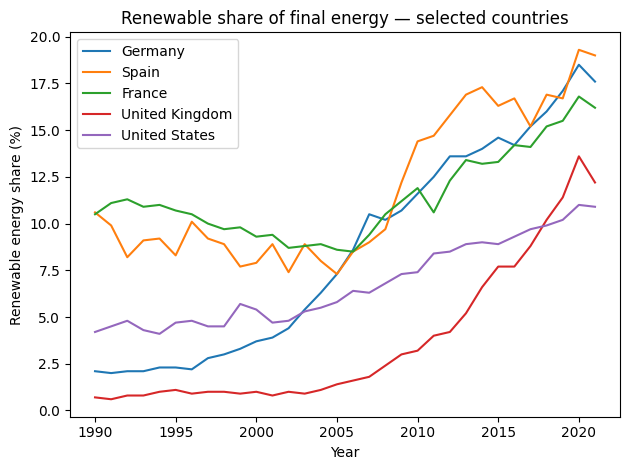

In [9]:
import matplotlib.pyplot as plt

countries = ["Germany","Spain","France","United Kingdom","United States"]
latest_year = df_wide["year"].max()

focus = df_wide[df_wide["country_name"].isin(countries)].copy()

plt.figure()
for c in countries:
    s = focus[focus["country_name"]==c].sort_values("year")
    plt.plot(s["year"], s["renew_share_pct"], label=c)
plt.xlabel("Year"); plt.ylabel("Renewable energy share (%)")
plt.title("Renewable share of final energy — selected countries")
plt.legend()
plt.tight_layout(); plt.show()


In [14]:
# last year with values in columns: renew_share_pct and co2_t_per_capita
mask = df_wide[["renew_share_pct","co2_t_per_capita"]].notna().all(axis=1)
latest_year = df_wide.loc[mask,"year"].max()
print("Last Year:", latest_year)

latest = df_wide[df_wide["year"]==latest_year].dropna(
    subset=["renew_share_pct","co2_t_per_capita"]
)


Last Year: 2020


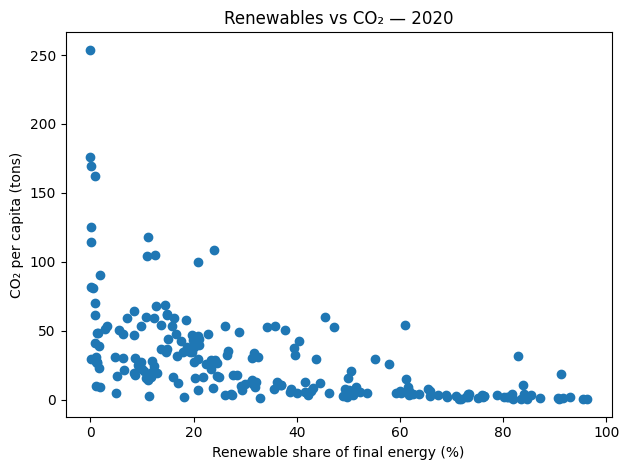

metric,country_name,renew_share_pct,co2_t_per_capita
3393,"Congo, Dem. Rep.",96.2,0.260678
15377,Somalia,95.5,0.319477
2852,Central African Republic,90.9,0.354257
2357,Burundi,83.4,0.467072
10740,Malawi,71.5,0.677089
12772,Niger,81.9,0.722605
2982,Chad,71.9,0.753825
10675,Madagascar,84.7,0.778156
14476,Rwanda,81.7,0.840993
14971,Sierra Leone,75.1,1.018221


In [20]:
plt.figure()
plt.scatter(latest["renew_share_pct"], latest["co2_t_per_capita"])
plt.xlabel("Renewable share of final energy (%)")
plt.ylabel("CO₂ per capita (tons)")
plt.title(f"Renewables vs CO₂ — {latest_year}")
plt.tight_layout()
plt.show()

latest[["country_name","renew_share_pct","co2_t_per_capita"]]\
    .sort_values("co2_t_per_capita").head(10)

